<a href="https://colab.research.google.com/github/codecrap/qctrl-qchack-Estonia/blob/main/system_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qctrl qctrl-visualizer qctrl-open-controls

In [408]:
import matplotlib.pyplot as plt
import numpy as np
import math
from pprint import pprint
from itertools import product

from qctrlvisualizer import get_qctrl_style, plot_controls
from qctrl import Qctrl

qctrl = Qctrl()
plt.style.use(get_qctrl_style())

# Definitions
---

In [525]:
# Define standard matrices
sigma_x = np.array([[0, 1], [1, 0]], dtype=np.complex)
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=np.complex)
sigma_z = np.array([[1, 0], [0, -1]], dtype=np.complex)

total_duration = 50  # ns
shot_count = 1024

# Define parameters of the Gaussian pulses to probe the filter
max_width = total_duration / 4.0
mean_values = np.linspace(max_width, total_duration - max_width, 6)
width_values = np.linspace(max_width / 8.0, max_width / 2.0, 4)

# Define sampled times
segments = 255
t_values = np.linspace(0.0, total_duration, segments + 1)

# Define Gaussian pulse, normalized to generate pi-pulses
# pi * gauss_normalized(..) = 
def gauss_pulse_operation(t, mean, width):
  return qctrl.operations.exp(-0.5 * ((t - mean) / width) ** 2.0) * qctrl.operations.sqrt(0.5 * np.pi / width ** 2.0)

def gaussian(t, amp, mean, width):
  return amp * np.exp(-0.5 * ((t - mean) / width) ** 2.0) #* np.sqrt(0.5 / np.pi / width ** 2.0)

def estimate_probability_of_one(measurements):
  size = len(measurements)
  probability = np.mean(measurements)
  standard_error = np.std(measurements) / np.sqrt(size)
  return (probability, standard_error)

def estimate_probabilities(M):
  P = []
  for m in M:
    size = len(m)
    p0 = m.count(0) / size
    p1 = m.count(1) / size
    p2 = m.count(2) / size
    P.append([p0,p1,p2])
  return P

In [ ]:
print(list(zip(mean_values, width_values)))

[(1.6666666666666665e-07, 2.083333333333333e-08), (3e-07, 4.166666666666666e-08), (4.3333333333333335e-07, 6.25e-08), (5.666666666666666e-07, 8.333333333333333e-08)]


# Single amplitude sweep for fixed $(\mu, \sigma)$
---




In [574]:
amplitudes = np.linspace(0.001,1,100)
controls = []
for amp in amplitudes:
  I = np.array([gaussian(t, amp, mean_values[2], width_values[2]) for t in t_values])
  Q = np.zeros(segments+1) # amp/2*np.ones(segments+1) #
  # I = 0.5*np.random.random(segments+1)
  # Q = 0.5*np.random.random(segments+1)
  values = I + 1j*Q
  controls.append({"duration": total_duration, "values": values}) #, "mean": mean, "width": width})


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


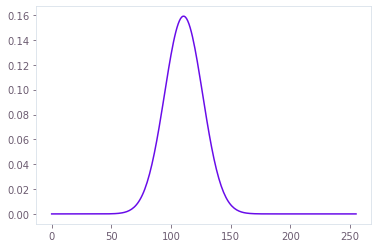

In [ ]:
plt.plot(controls[-1]["values"]/(2*np.pi)) #np.array([gaussian_pulse(1, t, mean_values[2], width_values[2]) for t in t_values]))

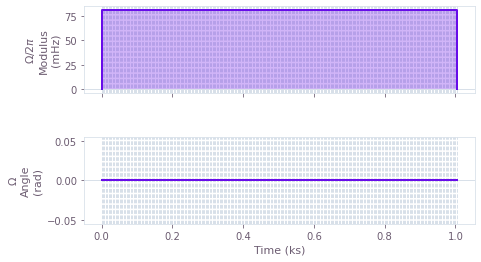

In [ ]:
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": total_duration / segments, "value": value} for value in controls[50]["values"]
        ]
    },
)

In [577]:
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 23s.


In [579]:
measurement_results = experiment_results.measurements
print(len(measurement_results))
probabilities, errors = [], []
for result in measurement_results:
  p,e = estimate_probability_of_one(result)
  probabilities.append(p)
  errors.append(e)


100


In [580]:
print(np.array(measurement_results).shape)
print(measurement_results[-1].count(2))
print(np.max(probabilities))

(100, 1024)
0
0.87890625


<ErrorbarContainer object of 3 artists>

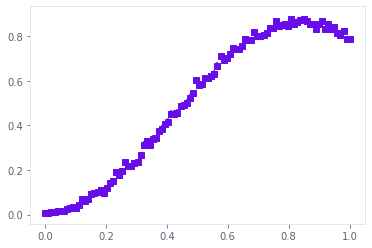

In [581]:
plt.errorbar(
        amplitudes,
        probabilities,
        yerr=errors,
        fmt="s",
    )

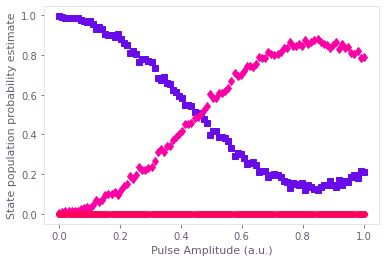

In [583]:
P = np.array(estimate_probabilities(measurement_results))
# print(P[-40,:])
plt.plot(amplitudes, P[:,0], 's', amplitudes, P[:,1], 'd', amplitudes, P[:,2], 'o')
plt.xlabel("Pulse Amplitude (a.u.)")
plt.ylabel("State population probability estimate")
plt.savefig("amplitude.png", dpi=256)

# Amplitude calibration
---

In [532]:
amplitudes = np.linspace(0.001,1,100)
max_amps = []

for width,mean in product(width_values, mean_values):
  controls = []
  for amp in amplitudes:
    I = np.array([gaussian(t, amp, mean, width) for t in t_values])
    Q = np.zeros(segments+1) # amp/2*np.ones(segments+1) #
    values = I + 1j*Q
    controls.append({"duration": total_duration, "values": values})

  experiment_results = qctrl.functions.calculate_qchack_measurements(controls=controls, shot_count=shot_count)
  measurement_results = experiment_results.measurements
  probabilities, errors = [], []
  for result in measurement_results:
    p,e = estimate_probability_of_one(result)
    probabilities.append(p)
    errors.append(e)
  
  max_amps.append( amplitudes[probabilities == np.max(probabilities)] )



Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 14s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 12s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 12s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 10s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 23s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 8s.


Your task calculate_qchack_measurements is currently in a queue waiting to be processed.
Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 8s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 12s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 8s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 10s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 19s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 12s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 8s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 10s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 8s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 8s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 10s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 8s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 10s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 12s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 10s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 14s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 12s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 60s.


[array([1.]) array([1.]) array([0.98990909]) array([1.])
 array([0.96972727]) array([0.98990909]) array([0.97981818])
 array([0.97981818]) array([0.98990909]) array([1.]) array([1.])
 array([0.96972727]) array([0.82845455]) array([0.778])
 array([0.74772727, 0.84863636]) array([0.84863636]) array([0.85872727])
 array([0.74772727]) array([0.62663636]) array([0.59636364])
 array([0.62663636]) array([0.60645455]) array([0.60645455, 0.65690909])
 array([0.63672727])]
[1.0, 1.0, 0.989909090909091, 1.0, 0.9697272727272728, 0.989909090909091, 0.9798181818181818, 0.9798181818181818, 0.989909090909091, 1.0, 1.0, 0.9697272727272728, 0.8284545454545454, 0.778, 0.7477272727272728, 0.8486363636363636, 0.8587272727272728, 0.7477272727272728, 0.6266363636363637, 0.5963636363636364, 0.6266363636363637, 0.6064545454545455, 0.6064545454545455, 0.6367272727272728]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


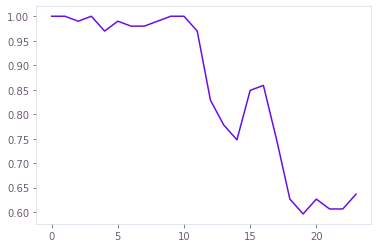

In [542]:
print(np.array(max_amps).flatten())
print([a[0] for a in max_amps])
plt.plot([a[0] for a in max_amps])
max_amps_list = [a[0] for a in max_amps]

# Filter optimization
---

In [545]:
controls = []
for amp, (width,mean) in zip(max_amps_list, product(width_values, mean_values)):
  print(amp,width,mean)
  I = np.array([gaussian_pulse(t, amp, mean, width) for t in t_values])
  Q = np.zeros(segments+1)
  values = I + 1j*Q
  controls.append({"duration": total_duration, "values": values}) #, "mean": mean, "width": width})
# pprint(controls)

1.0 1.5625 12.5
1.0 1.5625 17.5
0.989909090909091 1.5625 22.5
1.0 1.5625 27.5
0.9697272727272728 1.5625 32.5
0.989909090909091 1.5625 37.5
0.9798181818181818 3.125 12.5
0.9798181818181818 3.125 17.5
0.989909090909091 3.125 22.5
1.0 3.125 27.5
1.0 3.125 32.5
0.9697272727272728 3.125 37.5
0.8284545454545454 4.6875 12.5
0.778 4.6875 17.5
0.7477272727272728 4.6875 22.5
0.8486363636363636 4.6875 27.5
0.8587272727272728 4.6875 32.5
0.7477272727272728 4.6875 37.5
0.6266363636363637 6.25 12.5
0.5963636363636364 6.25 17.5
0.6266363636363637 6.25 22.5
0.6064545454545455 6.25 27.5
0.6064545454545455 6.25 32.5
0.6367272727272728 6.25 37.5


In [489]:
print(len(controls[-1]["values"]))

256


In [546]:
wm_arr = np.array([a[0] for a in list(product(width_values, mean_values))])
print(wm_arr.shape)
shape = (len(width_values), len(mean_values))
print(wm_arr.reshape(shape))

(24,)
[[1.5625 1.5625 1.5625 1.5625 1.5625 1.5625]
 [3.125  3.125  3.125  3.125  3.125  3.125 ]
 [4.6875 4.6875 4.6875 4.6875 4.6875 4.6875]
 [6.25   6.25   6.25   6.25   6.25   6.25  ]]


In [548]:
list(zip(max_amps_list, product(width_values, mean_values)))

[(1.0, (1.5625, 12.5)),
 (1.0, (1.5625, 17.5)),
 (0.989909090909091, (1.5625, 22.5)),
 (1.0, (1.5625, 27.5)),
 (0.9697272727272728, (1.5625, 32.5)),
 (0.989909090909091, (1.5625, 37.5)),
 (0.9798181818181818, (3.125, 12.5)),
 (0.9798181818181818, (3.125, 17.5)),
 (0.989909090909091, (3.125, 22.5)),
 (1.0, (3.125, 27.5)),
 (1.0, (3.125, 32.5)),
 (0.9697272727272728, (3.125, 37.5)),
 (0.8284545454545454, (4.6875, 12.5)),
 (0.778, (4.6875, 17.5)),
 (0.7477272727272728, (4.6875, 22.5)),
 (0.8486363636363636, (4.6875, 27.5)),
 (0.8587272727272728, (4.6875, 32.5)),
 (0.7477272727272728, (4.6875, 37.5)),
 (0.6266363636363637, (6.25, 12.5)),
 (0.5963636363636364, (6.25, 17.5)),
 (0.6266363636363637, (6.25, 22.5)),
 (0.6064545454545455, (6.25, 27.5)),
 (0.6064545454545455, (6.25, 32.5)),
 (0.6367272727272728, (6.25, 37.5))]

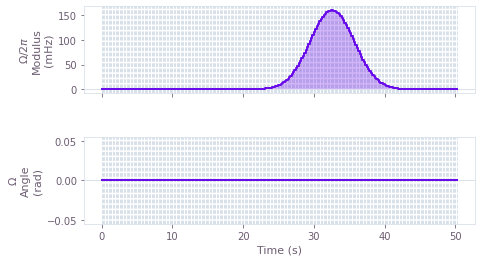

In [549]:
plot_controls(
    figure=plt.figure(),
    controls={
        "$\Omega$": [
            {"duration": total_duration / segments, "value": value} for value in controls[10]["values"]
        ]
    },
)

In [550]:
experiment_results = qctrl.functions.calculate_qchack_measurements(
    controls=controls,
    shot_count=shot_count,
)

Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 5s.


In [557]:
measurement_results = experiment_results.measurements
print(len(measurement_results))
probabilities, errors = [], []
for result in measurement_results:
  p,e = estimate_probability_of_one(result)
  probabilities.append(p)
  errors.append(e)
probabilities = np.array(probabilities).reshape(shape[::-1])
errors = np.array(errors).reshape(shape[::-1])

24


In [558]:
[a for b in measurement_results for a in b].count(2)

0

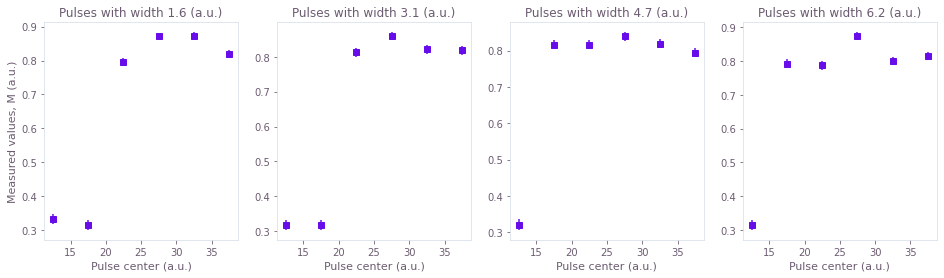

In [559]:
# Plot inputs
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].set_ylabel("Measured values, M (a.u.)")
for n in range(len(width_values)):
    axs[n].set_title(f"Pulses with width {width_values[n] * 1:.1f} (a.u.)")
    axs[n].set_xlabel("Pulse center (a.u.)")
    axs[n].errorbar(
        mean_values,
        probabilities[:,n],
        yerr=errors[:,n],
        fmt="s",
    )

## Parameter extraction
---

In [560]:
with qctrl.create_graph() as graph:

  # Parameters to estimate
  mu = qctrl.operations.bounded_optimization_variable(
      count=1, lower_bound=0.0, upper_bound=total_duration, name="mu"
  )
  sigma = qctrl.operations.bounded_optimization_variable(
      count=1, lower_bound=0.01*total_duration, upper_bound=total_duration, name="sigma"
  )
  a = qctrl.operations.unbounded_optimization_variable(
      count=1, initial_lower_bound=-1.0, initial_upper_bound=1.0, name="a"
  )
  b = qctrl.operations.unbounded_optimization_variable(
      count=1, initial_lower_bound=-1.0, initial_upper_bound=1.0, name="b"
  )

  # Create Hamiltonian term
  # Create a 2D batch of signals with all values of mean and width you want to simulate.
  # This batch is preserved through the entire computation, which ends up being faster than
  # looping through all values.
  alpha = qctrl.operations.pwc_signal(
      values=gauss_pulse_operation(
          t_values[None, None, :],
          mean_values[:, None, None],
          width_values[None, :, None],
      ),
      duration=total_duration,
      name="alpha",
  )

  gauss_filter = qctrl.operations.gaussian_integral_function(std=sigma, offset=mu)
  alpha_filtered = qctrl.operations.convolve_pwc(
      pwc=alpha, kernel_integral=gauss_filter
  )
  shift = qctrl.operations.stf_operator(signal=alpha_filtered, operator=0.5 * sigma_x)

  # Calculate |0> -> |1> transfer probability
  calculated_populations = 1.0 - qctrl.operations.infidelity_stf(
      sample_times=t_values,
      hamiltonian=shift,
      target_operator=qctrl.operations.target(operator=np.array([[0, 1], [0, 0]])),
      name="infidelities",
  )

  # Create measured points
  calculated_points = a * calculated_populations + b
  calculated_points.name = "calculated_points"

  # Calculate cost
  cost = qctrl.operations.sum(
      (calculated_points - probabilities) ** 2.0
      / (2.0 * errors ** 2.0),
      name="cost",
  )

  # Calculate Hessian
  hessian = qctrl.operations.hessian_matrix(cost, [mu, sigma, a, b], name="hessian")
  
  # Estimate the parameters
  result = qctrl.functions.calculate_optimization(
    cost_node_name="cost",
    output_node_names=["mu", "sigma", "a", "b", "hessian"],
    optimization_count=10,
    graph=graph,
  )

  estimated_mu = result.output["mu"]["value"][0]
  estimated_sigma = result.output["sigma"]["value"][0]
  estimated_a = result.output["a"]["value"][0]
  estimated_b = result.output["b"]["value"][0]

  # Calculate 2-sigma uncertainties (error bars give 95% precision)
  hessian = result.output["hessian"]["value"]
  uncertainties = 2.0 * np.sqrt(np.diag(np.linalg.inv(hessian)))
  uncertainty_mu, uncertainty_sigma, uncertainty_a, uncertainty_b = uncertainties


Your task calculate_optimization has started.
Your task calculate_optimization has completed in 46s.


In [561]:
def population(pulse_widths, pulse_means, filter_sigma, filter_mu):
    """
    Calculates the transfer probability between states |0> and |1> for a
    batch of Gaussian pulses with given widths and means, while applying
    a Gaussian filter to the pulses with a given cutoff frequency and offset.
    """

    def gaussian_pulse(t, mean, width):
        return np.exp(-0.5 * ((t - mean) / width) ** 2.0) * np.sqrt(
            0.5 * np.pi / width ** 2.0
        )

    with qctrl.create_graph() as graph:
        alpha = qctrl.operations.pwc_signal(
            gaussian_pulse(
                t_values[None, None, :],
                pulse_means[:, None, None],
                pulse_widths[None, :, None],
            ),
            total_duration,
        )

        shift = qctrl.operations.stf_operator(
            signal=qctrl.operations.convolve_pwc(
                pwc=alpha,
                kernel_integral=qctrl.operations.gaussian_integral_function(
                    std=filter_sigma,
                    offset=filter_mu,
                ),
            ),
            operator=0.5 * sigma_x,
        )

        population = 1.0 - qctrl.operations.infidelity_stf(
            sample_times=t_values,
            hamiltonian=shift,
            target_operator=qctrl.operations.target(np.array([[0, 1], [0, 0]])),
        )
        population.name = "populations"

    graph_result = qctrl.functions.calculate_graph(
        graph=graph,
        output_node_names=["populations"],
    )
    return graph_result.output["populations"]["value"]


In [562]:
mean_range = np.linspace(0.1 * total_duration, 0.9 * total_duration, 30)

calculated_curves = estimated_b + estimated_a * population(
    pulse_widths=width_values,
    pulse_means=mean_range,
    filter_mu=estimated_mu,
    filter_sigma=estimated_sigma,
)

# ideal_curves = actual_b + actual_a * population(
#     pulse_widths=width_values,
#     pulse_means=mean_range,
#     filter_mu=actual_mu,
#     filter_sigma=actual_sigma,
# )


Your task calculate_graph has completed in 3s.


estimated sigma = (0.500 ± 0.381) au
estimated mu = (31.653 ± 0.147) au
estimated a = (-0.494 ± 0.016) au
estimated b = (0.844 ± 0.006) au


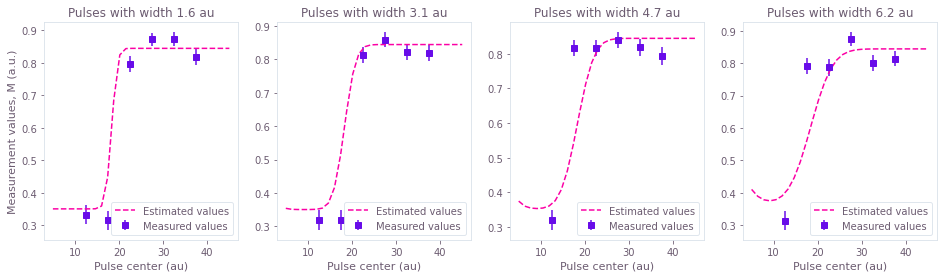

In [569]:
# Print parameter estimates
print(f"estimated sigma = ({estimated_sigma:.3f} ± {uncertainty_sigma:.3f}) au")

print(f"estimated mu = ({estimated_mu:.3f} ± {uncertainty_mu:.3f}) au")

print(f"estimated a = ({estimated_a:.3f} ± {uncertainty_a:.3f}) au")

print(f"estimated b = ({estimated_b:.3f} ± {uncertainty_b:.3f}) au")

# Plot results
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].set_ylabel("Measurement values, M (a.u.)")

for n in range(len(width_values)):
    axs[n].set_title(f"Pulses with width {width_values[n]:.1f} au")
    axs[n].set_xlabel("Pulse center (au)")
    axs[n].errorbar(
        mean_values,
        probabilities[:,n],
        yerr=2.0 * errors[:,n],
        fmt="s",
        color="C0",
        label="Measured values",
    )

    axs[n].plot(
        mean_range,
        calculated_curves[:,n],
        "--",
        label="Estimated values",
        color="C1",
    )
    axs[n].legend(loc=4)

plt.savefig("filter.png", dpi=256)


# Constant Hamiltonian term estimation
---

In [434]:
# range of wait times in the different experiments
wait_times = np.linspace(1, 100, 20)

# list of initial states
initial_states = np.array(
    [
        [[1.0 + 0.0j], [0.0 + 0.0j]],
        [[1.0 + 0.0j], [1.0 + 0.0j]] / np.sqrt(2.0),
        [[1.0 + 0.0j], [0.0 + 1.0j]] / np.sqrt(2.0),
    ]
)
initial_state_names = [
    r"$\vert 0 \rangle$",
    r"$(\vert 0 \rangle + \vert 1 \rangle)/\sqrt{2}$",
    r"$(\vert 0 \rangle +i \vert 1 \rangle)/\sqrt{2}$",
]

# list of states whose population will be measured at the end
projector_states = np.array(
    [
        [[1.0 + 0.0j], [0.0 + 1.0j]] / np.sqrt(2.0),
        [[1.0 + 0.0j], [0.0 + 0.0j]],
        [[1.0 + 0.0j], [1.0 + 0.0j]] / np.sqrt(2.0),
    ]
)
projector_state_names = [
    r"$(\vert 0 \rangle +i \vert 1 \rangle)/\sqrt{2}$",
    r"$\vert 0 \rangle$",
    r"$(\vert 0 \rangle + \vert 1 \rangle)/\sqrt{2}$",
]

In [ ]:
# define Hamiltonian
Hamiltonian = lambda Omegas: 0.5 * (
    Omegas[0] * sigma_x + Omegas[1] * sigma_y + Omegas[2] * sigma_z
)

# define unitaries for Hamiltonian
Ut = lambda t, Omegas: expm(-1.0j * t * Hamiltonian(Omegas))

# define function to calculate the populations given Omegas and wait times
# this function first calculates the unitaries for all wait times and then
# calculates the projected populations for different initial states and projectors.
# the return value is thefore in the shape of [len(projector_states), len(wait_times)]
def get_populations(Omegas, wait_times):
    unitaries = np.array([Ut(t, Omegas) for t in wait_times])
    return np.array(
        [
            np.abs(
                np.matmul(
                    projector_state.conj().T, np.matmul(unitaries, initial_state)
                ).flatten()
            )
            ** 2
            for projector_state, initial_state in zip(projector_states, initial_states)
        ]
    )


# Pickle test
---

In [598]:
NOT = np.array([ 0.31209867-0.19643832j,  0.14533233-0.0174159j,
0.03519855+0.07436375j, -0.06475012-0.39443288j,
-0.59260967+0.35004789j,  0.23800035+0.09241289j,
0.17528884+0.0232753j ,  0.26635219-0.41861981j,
-0.05800045+0.09432613j,  0.09115755+0.38281929j], dtype=np.complex)
print(NOT)


[ 0.31209867-0.19643832j  0.14533233-0.0174159j   0.03519855+0.07436375j
 -0.06475012-0.39443288j -0.59260967+0.35004789j  0.23800035+0.09241289j
  0.17528884+0.0232753j   0.26635219-0.41861981j -0.05800045+0.09432613j
  0.09115755+0.38281929j]


In [591]:
!pip install jsonpickle

In [594]:
import jsonpickle.ext.numpy as jsonpickle_numpy
import jsonpickle
import numpy as np

jsonpickle_numpy.register_handlers()

not_control = {"duration": 100, "value": NOT}
json_not_control = jsonpickle.encode(not_control)
with open("not_control.json", "w") as file:
    file.write(json_not_control)

print(json_not_control)

{"duration": 100, "value": {"py/object": "numpy.ndarray", "dtype": "complex128", "values": [{"py/object": "builtins.complex", "py/newargs": {"py/tuple": [0.31209867, -0.19643832]}}, {"py/object": "builtins.complex", "py/newargs": {"py/tuple": [0.14533233, -0.0174159]}}, {"py/object": "builtins.complex", "py/newargs": {"py/tuple": [0.03519855, 0.07436375]}}, {"py/object": "builtins.complex", "py/newargs": {"py/tuple": [-0.06475012, -0.39443288]}}, {"py/object": "builtins.complex", "py/newargs": {"py/tuple": [-0.59260967, 0.35004789]}}, {"py/object": "builtins.complex", "py/newargs": {"py/tuple": [0.23800035, 0.09241289]}}, {"py/object": "builtins.complex", "py/newargs": {"py/tuple": [0.17528884, 0.0232753]}}, {"py/object": "builtins.complex", "py/newargs": {"py/tuple": [0.26635219, -0.41861981]}}, {"py/object": "builtins.complex", "py/newargs": {"py/tuple": [-0.05800045, 0.09432613]}}, {"py/object": "builtins.complex", "py/newargs": {"py/tuple": [0.09115755, 0.38281929]}}]}}
